In [2]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pickle
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from scipy import stats

# Problem 2: MNIST data

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

For ease of computation, we look as the first 5000 samples of the data

In [3]:
X , Y= train_X.reshape(train_X.shape[0],-1)[:5000,], train_y[:5000]

My version of k-means algorithm

In [86]:
def k_means(X, k, init_mean = None, init_cluster = None, max_iter = None):
    '''
    type X: ndarray (n,p)
    type k: int
    type init_mean: ndarray (k,)
    type init_cluster: ndarray(n,)
    rtype: (ndarray (n,), ndarray(k,p))
    '''
    if not init_cluster is None:
        cluster = init_cluster
        mean = np.zeros((k,X.shape[1]))
        next_step = "E"
    elif not init_mean is None:
        mean = init_mean
        cluster = np.zeros(X.shape[0], dtype= int)
        next_step = "M"
    n, p = X.shape
    num_changed = 100
    n_iter = 0 
    while num_changed:
        if next_step =="E":
            for i in range(k):
                mean[i,] = np.mean(X[cluster==i], axis = 0)
            next_step = "M"
            
        if next_step =="M":
            num_changed = 0
            for i in range(n):
                d = np.argmin(np.apply_along_axis(lambda mu: LA.norm(mu - X[i]),
                                                 1, mean))
                if not cluster[i] == d:
                    num_changed += 1
                    cluster [i] = d
            next_step = "E"
        n_iter += 1
        print("%2d th iteration, number of changes: %2d" %(n_iter, num_changed))
        if not max_iter is None and n_iter > max_iter:
            break
    return (cluster, mean, n_iter)

In [87]:
def within_cluster_dist(X, cluster=None, mean = None):
    if cluster is None:
        cluster = np.zeros(X.shape[0], dtype= int)
        for i in range(n):
            cluster[i] = np.argmin(np.apply_along_axis(lambda mu: LA.norm(mu - X[i]),
                                                       1, mean))
    classes = np.unique(cluster)
    if mean is None:
        mean = np.zeros((len(classes), X.shape[1]))
        for i in classes:
            mean[i,] = np.apply_along_axis(np.mean, 0, X[cluster == i])
    
    W = 0
    for i in classes:
        W += np.sum(np.apply_along_axis(lambda x: LA.norm(x - mean[i]),
                                      1, X[cluster == i])**2) * np.sum(cluster==i)
    return W

In [6]:
n, K = X.shape[0], 10

**Random Partition initialization**

The Random Partition method first randomly assigns a cluster to each observation and then proceeds to the update step, thus computing the initial mean to be the centroid of the cluster's randomly assigned points.

In [7]:
random_cluster = np.random.choice(K, n)
print("Initial within-cluster distance: %10.3E" % within_cluster_dist(X, cluster = random_cluster))

Initial within-cluster distance:  8.547E+12


**Forgy method**

The Forgy method randomly chooses $k$ observations from the dataset and uses these as the initial means.

In [9]:
random_mean = X[np.random.choice(n, K, replace = False)]
print("Within-cluster distance: %10.3E" % within_cluster_dist(X, mean= random_mean))

Within-cluster distance:  4.556E+13


In pratice, **we found Random Partition initialization performs better** (more stably). We will use it thereafter.

## (a) Direct k-means on the data

$k=10$. We run k-means for 10 different initialization, and choose the one with smallest within-cluster distance.

In [ ]:
cluster_results = np.zeros((10, n), dtype= int)
for i in range(10):
    np.random.seed(i)
    random_cluster = np.random.choice(K, n)
    print("Initial within-cluster distance: %10.3E" % within_cluster_dist(X, cluster = random_cluster))
    cl, m, n_it = k_means(X, K, init_cluster = random_cluster)
    print("Final within-cluster distance: %10.3E" % within_cluster_dist(X, cluster=cl, mean=m))
    cluster_results[i, ] = cl

# Save result
with open("multi_times_kmeans.txt", "wb") as fp:   #Pickling
    pickle.dump(cluster_results, fp)

In [17]:
with open("multi_times_kmeans.txt", "rb") as fp:   # Unpickling
    cluster_results = pickle.load(fp)

In [8]:
dist_results = np.apply_along_axis(lambda c: within_cluster_dist(X, cluster=c),
                                   1, cluster_results)
cluster_final, within_cluster_dist_final = cluster_results[np.argmin(dist_results)], min(dist_results)

In [9]:
print(cluster_final)
print("Final within-cluster distance: %10.3E" % within_cluster_dist_final)

[6 9 8 ... 2 3 2]
Final within-cluster distance:  6.450E+12


 0 th cluser


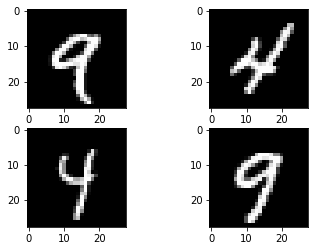

 1 th cluser


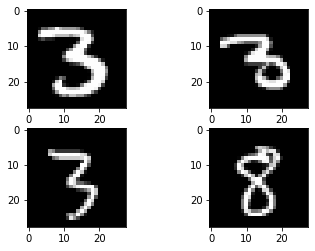

 2 th cluser


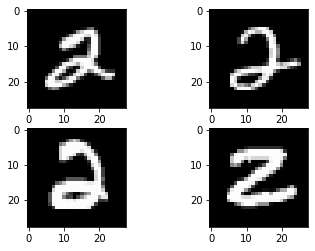

 3 th cluser


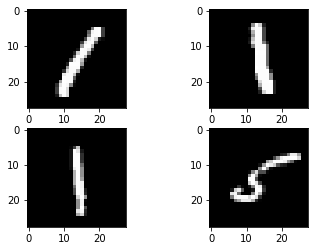

 4 th cluser


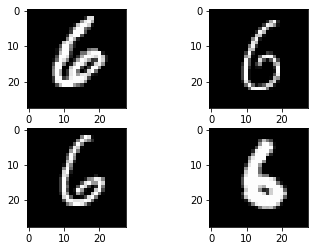

 5 th cluser


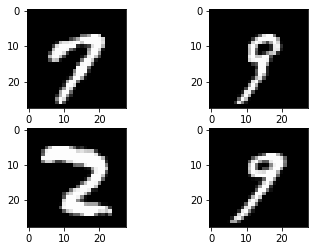

 6 th cluser


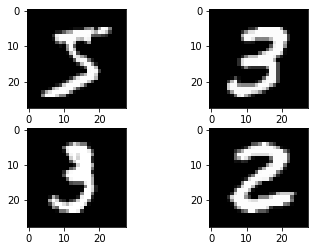

 7 th cluser


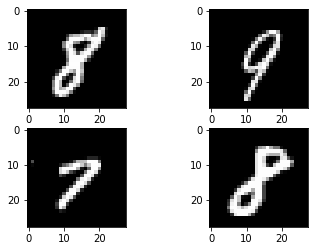

 8 th cluser


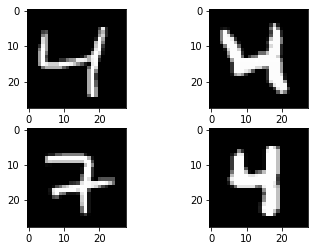

 9 th cluser


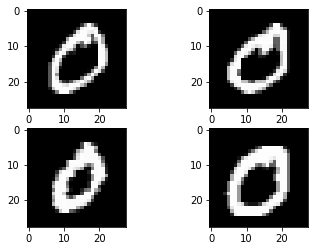

In [20]:
for i in range(10):
    print("%2d th cluser"%i)
    x = np.where(cluster_final==i)[0]
    plt.subplot(221)
    plt.imshow(train_X[x[0]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(222)
    plt.imshow(train_X[x[1]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(223)
    plt.imshow(train_X[x[2]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(224)
    plt.imshow(train_X[x[3]], cmap=pyplot.get_cmap('gray'))
    plt.show()

In [10]:
pd.crosstab(cluster_final, Y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,1,0,0,6,287,34,0,11,23,221
1,28,1,22,160,0,110,3,0,151,10
2,0,1,326,8,4,1,5,2,4,0
3,1,543,76,29,21,13,32,37,38,17
4,21,0,16,3,6,11,390,0,3,1
5,0,1,7,6,2,2,0,375,4,67
6,23,0,9,248,0,95,3,0,45,2
7,26,15,16,26,15,149,23,11,187,35
8,6,2,14,6,200,13,39,113,6,140


In [18]:
print(adjusted_rand_score(Y, cluster_final)) 
print(adjusted_rand_score(Y, np.random.choice(K,n))) # comparison

0.42574486374922754
9.377755902463445e-05


**Conclusion**: Most of the clusters identify a unique digit well. For example, the $i=9$ cluster are mostly the digit 0. However, in some clusters there is severe confusion. For example, in $i=8$ cluster, digits 4, 7, 9 are not well distinguished.

## (b) Spectral Clustering

In [88]:
from tqdm import tqdm
def distance_matrix(X):
    n = X.shape[0]
    D = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            D[i,j] = np.sum((X[i] - X[j])**2)
    return D+D.transpose()

In [22]:
D = distance_matrix(X)

with open("distance_matrix.txt", "wb") as fp:   #Pickling
    pickle.dump(D, fp)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.99it/s]


In [11]:
with open("distance_matrix.txt", "rb") as fp:   # Unpickling
    D = pickle.load(fp)

In [242]:
np.mean([np.min(np.delete(D[i], i)) for i in range(n)])

9861.5754

Average shortest distance around 100. choose $\sigma^2=10000$ ($\sigma=100$).

In [173]:
sigma_2 = 10000
W = np.exp(-D/(2*sigma_2))
L = np.diag(np.apply_along_axis(np.sum, 0, W)) - W
w, V = LA.eig(L)
V = V[:, np.argsort(w)]
w.sort()

with open("spectral_embedding.txt", "wb") as fp:   #Pickling
    pickle.dump(V, fp)

In [95]:
with open("spectral_embedding.txt", "rb") as fp:   # Unpickling
    V = pickle.load(fp)

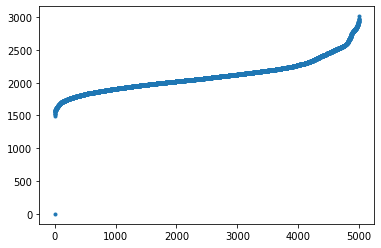

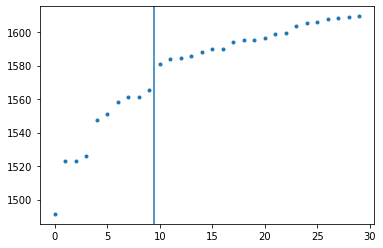

In [174]:
plt.plot(w, '.')
plt.show()
plt.plot(w[1:31], '.')
plt.axvline(x=9.5)
plt.show()

Define `X_embedded` as the first 10 **non-zero** eigenvectors of `W`.

In [193]:
X_embedded = V[:, 1:11]
X_embedded.shape

(5000, 10)

We then run k-means on `X_embedded`.

In [ ]:
spectral_cluster_results = np.zeros((10, n), dtype= int)
for i in range(10):
    np.random.seed(i)
    random_cluster = np.random.choice(K, n)
    print("Initial within-cluster distance: %10.3E" % within_cluster_dist(X_embedded, cluster = random_cluster))
    cl, m, n_it = k_means(X_embedded, K, init_cluster = random_cluster)
    print("Final within-cluster distance: %10.3E" % within_cluster_dist(X_embedded, cluster=cl, mean=m))
    spectral_cluster_results[i, ] = cl

# Save result
with open("multi_times_spectral_clustering.txt", "wb") as fp:   #Pickling
    pickle.dump(spectral_cluster_results , fp)

In [238]:
with open("multi_times_spectral_clustering.txt", "rb") as fp:   # Unpickling
    spectral_cluster_results = pickle.load(fp)

In [227]:
dist_results = np.apply_along_axis(lambda c: within_cluster_dist(X_embedded, cluster=c),
                                   1, spectral_cluster_results)
spectral_cluster_final, within_cluster_dist_final = spectral_cluster_results[np.argmin(dist_results)], min(dist_results)

In [228]:
print(spectral_cluster_final)
print("Final within-cluster distance: %10.3E" % within_cluster_dist_final)

[3 3 3 ... 3 3 3]
Final within-cluster distance:  5.158E+00


In [229]:
unique_elements, counts_elements = np.unique(spectral_cluster_final, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9]
 [  56    1    2 4934    2    1    1    1    1    1]]


It seems that the result with the minimum within-cluster distance gives a very unbalenced grouping. Most training samples are assigned in the same cluster (the $i=3$ cluster).

To give a more meaningful clustering, we try to find relatively more **diversed** clustering results. Particularly, We will find the result with largest cross entropy. 

In [230]:
entropy_results = np.apply_along_axis(lambda x: stats.entropy(np.unique(x, return_counts=True)[1]),
                                      1, spectral_cluster_results)
spectral_cluster_final = spectral_cluster_results[np.argmax(entropy_results)]
within_cluster_dist_final = within_cluster_dist(X_embedded, cluster=spectral_cluster_final)

In [231]:
print(entropy_results)
print(spectral_cluster_final)
print("Final within-cluster distance: %10.3E" % within_cluster_dist_final)

[0.73731059 0.90570424 0.49411141 0.07990099 0.7374832  0.63375632
 0.80253085 0.49400676 0.49411141 0.90598149]
[1 5 1 ... 5 5 5]
Final within-cluster distance:  1.221E+01


In [240]:
unique_elements, counts_elements = np.unique(spectral_cluster_final, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements))) # very unbalanced

Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9]
 [   2 1372    2    1   29 3256    2    3  179  154]]


This is still quite unbalanced, though a bit better than the previous clustering. 

 1 th cluser


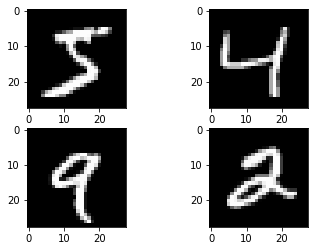

 4 th cluser


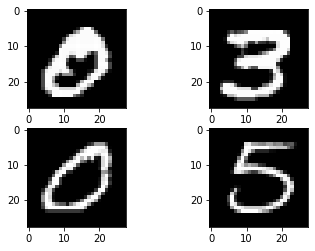

 5 th cluser


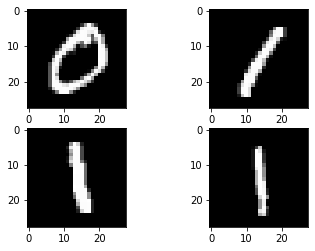

 8 th cluser


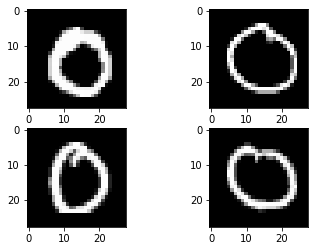

 9 th cluser


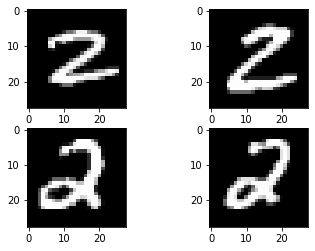

In [233]:
for i in range(10):    
    x = np.where(spectral_cluster_final==i)[0]
    if len(x)<4: continue
    print("%2d th cluser"%i)
    plt.subplot(221)
    plt.imshow(train_X[x[0]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(222)
    plt.imshow(train_X[x[1]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(223)
    plt.imshow(train_X[x[2]], cmap=pyplot.get_cmap('gray'))
    plt.subplot(224)
    plt.imshow(train_X[x[3]], cmap=pyplot.get_cmap('gray'))
    plt.show()

In [235]:
pd.crosstab(spectral_cluster_final, Y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,0,0,0,0,0,0,0,0,2,0
1,76,2,229,223,107,133,183,46,259,114
2,2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1
4,8,0,2,3,1,2,2,0,11,0
5,216,561,219,234,427,275,292,504,149,379
6,1,0,0,0,0,0,0,0,1,0
7,2,0,0,0,0,0,0,0,1,0
8,155,0,4,4,0,10,5,0,1,0


In [239]:
print(adjusted_rand_score(Y, cluster_final)) 
print(adjusted_rand_score(Y, spectral_cluster_final)) # worse than direct k-means

0.42574486374922754
0.03916223091326004


Note that the clustering given by spectral clustering on the radial kernel similarity matrix is very unbalanced, and it performs much worse than the ordinary k-means method applied directly on `X`. However, it is not entirely worthless. For example, the $i=8$ group successfully identifies digit 0. I also tried different values of $\sigma$ and different number of eigenvectors, but didn't see much improvement in the performance.

My conclusion is for this problem, the Euclidean distance may be a more appropriate similarity metric than the gaussian kernel.

# Problem 3: Genome data

In [120]:
import scipy.io
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

In [3]:
data = scipy.io.loadmat('genomedata.mat')['X']
n = data.shape[0]
data = np.array([data[i][0][0].split() for i in range(n)])

In [59]:
np.unique(data)

array(['--', 'AA', 'AC', 'AG', 'CC', 'GG', 'TC', 'TG', 'TT'], dtype='<U2')

**One-hot encoding**

In [30]:
enc.fit([[s]*1043 for s in np.unique(data)[1:]])

OneHotEncoder(handle_unknown='ignore')

In [62]:
data_onehot = enc.transform(data).toarray()
data_onehot.shape

(5000, 8344)

## (a) PCA

In [64]:
pca = PCA()
pca.fit(data_onehot)

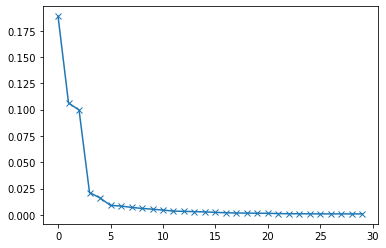

In [73]:
plt.plot(pca.explained_variance_ratio_[:30], 'x-')
plt.show()

It seems that the first 3 principal components are most important.

In [121]:
data_PCA = pca.transform(data_onehot)[:,:3]

Scatter plot matrix of the 1st, 2nd, and 3rd principal components.

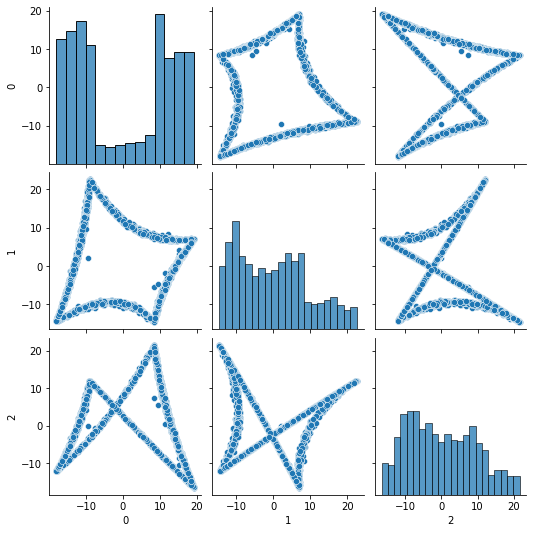

In [138]:
df = pd.DataFrame(data_PCA)
sns.pairplot(df)

3-D view

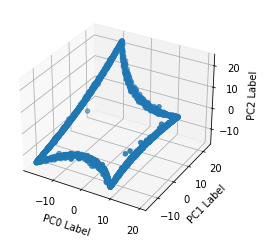

In [124]:
for i, j, k in [(0,1,2)]:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data_PCA[:,i], data_PCA[:,j], data_PCA[:,j])
    ax.set_xlabel('PC%1d Label'%i)
    ax.set_ylabel('PC%1d Label'%j)
    ax.set_zlabel('PC%1d Label'%k)

    plt.show()

In [125]:
kmeans_PCA = KMeans(n_clusters=3, random_state=0).fit(data_PCA)

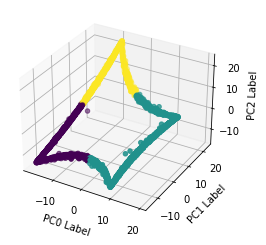

In [126]:
for i, j, k in [(0,1,2)]:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data_PCA[:,i], data_PCA[:,j], data_PCA[:,j], c=kmeans_PCA.labels_)
    ax.set_xlabel('PC%1d Label'%i)
    ax.set_ylabel('PC%1d Label'%j)
    ax.set_zlabel('PC%1d Label'%k)

    plt.show()

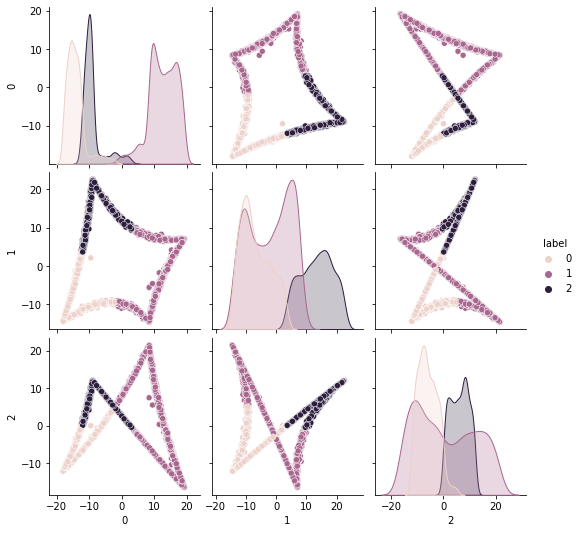

In [139]:
df["label"] = kmeans_PCA.labels_
sns.pairplot(df, hue="label")

 K-means clustering on the principal components does not seem very meaningful.

## (b) Diffusion map

The diffusion map $P = D^{-1} W $ essentially share the same eigenvectors of the normalized Laplacian $L_N = I - D^{-1}W$.

In [89]:
D = distance_matrix(data_onehot)

with open("distance_matrix_genome.txt", "wb") as fp:   #Pickling
    pickle.dump(D, fp)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:27<00:00, 24.15it/s]


In [92]:
with open("distance_matrix_genome.txt", "rb") as fp:   # Unpickling
    D = pickle.load(fp)

(5000, 5000)

In [96]:
np.mean([np.min(np.delete(D[i], i)) for i in range(n)]), np.std([np.min(np.delete(D[i], i)) for i in range(n)])

(530.124, 321.5895959511128)

Therefore we choose $\sigma^2 =530$ to characterize the average neighborhood distance.

Next, we compute `w` and `V` to be the eigenvalues of eigenvectors of the normalized Laplacian, respectively.

In [104]:
sigma_2 = 530
W = np.exp(-D/(2*sigma_2))
L_n = np.eye(n)- np.matmul(np.diag(1/np.apply_along_axis(np.sum, 0, W)), W)
w, V = LA.eig(L_n.transpose())
V = V[:, np.argsort(w)]
w.sort()

with open("diffusion_map.txt", "wb") as fp:   #Pickling
    pickle.dump(V, fp)

In [99]:
with open("diffusion_map.txt", "rb") as fp:   # Unpickling
    V = pickle.load(fp)

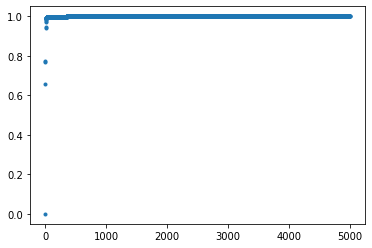

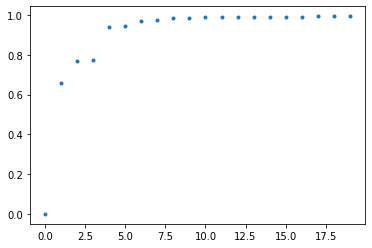

In [108]:
plt.plot(w, '.')
plt.show()
plt.plot(w[:20], '.')
plt.show()

The eigenvalue plot also indicates that there are three most obvious clusters. Therefore we look at the first three **non-zero** eigenvectors of $L_n$.

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

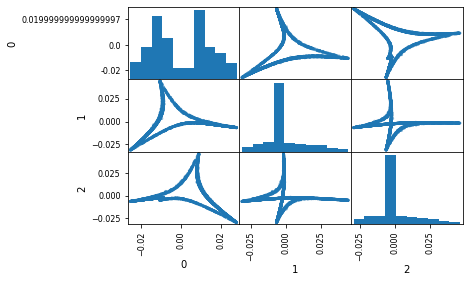

In [140]:
df = pd.DataFrame(V[:, 1:4])
pd.plotting.scatter_matrix(df)

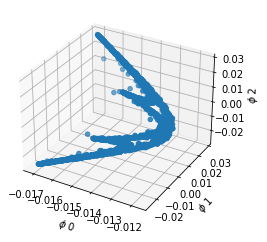

In [114]:
for i, j, k in [(0,1,2)]:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(V[:,i], V[:,j], V[:,j])
    ax.set_xlabel(r'$\phi $%2d '%i)
    ax.set_ylabel(r'$\phi $%2d '%j)
    ax.set_zlabel(r'$\phi $%2d '%k)

    plt.show()

Next, we apply k-means on the 3-dimensional diffusion map, with $k=3$

In [141]:
kmeans_diffusion = KMeans(n_clusters=3, random_state=0).fit(V[:,1:4])

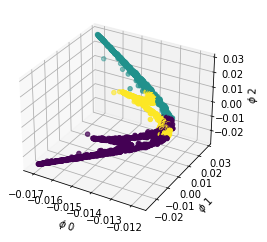

In [142]:
for i, j, k in [(0,1,2)]:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(V[:,i], V[:,j], V[:,j], c=kmeans_diffusion.labels_)
    ax.set_xlabel(r'$\phi $%2d '%i)
    ax.set_ylabel(r'$\phi $%2d '%j)
    ax.set_zlabel(r'$\phi $%2d '%k)

    plt.show()

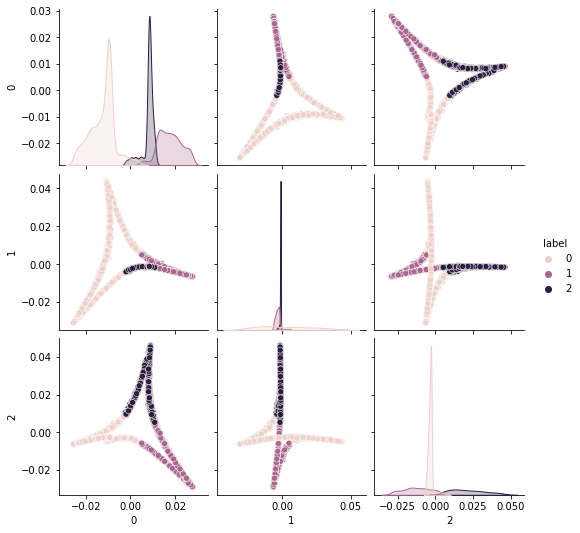

In [143]:
df['label'] = kmeans_diffusion.labels_
sns.pairplot(df, hue="label")

From the plots above, especially the histograms, we see that the clusters are better seperated using diffusion maps than using principal components.